In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import operator

In [40]:
dataset_cancer = pd.read_csv("cancer.csv")
dataset_spam = pd.read_csv("spam.csv")
values_cancer = dataset_cancer.values.tolist()
spam_initial_values = dataset_spam.values
values_spam = np.c_[spam_initial_values[:, [-1]], np.delete(spam_initial_values, -1, axis=1)].tolist()

In [41]:
def euclidean_distance(x, y):
    distance = 0.0
    for i in range(len(x)):
        distance += (x[i] - y[i]) * (x[i] - y[i])
    return distance

In [42]:
def get_neighbors(values, test_instance, k):
    distances = []
    for x in range(len(values)):
        v = values[x]
        dist = euclidean_distance(test_instance[1:], v[1:])
        distances.append((v, dist))
    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for x in range(k):
        neighbors.append(distances[x][0])
    return neighbors

In [43]:
def get_response(neighbors):
    class_votes = {}
    for x in range(len(neighbors)):
        response = neighbors[x][0]
        if response in class_votes:
            class_votes[response] += 1
        else:
            class_votes[response] = 1
    sorted_votes = sorted(class_votes.items(), key=operator.itemgetter(1), reverse=True)
    return sorted_votes[0][0]

In [44]:
def get_result(data, new_data, k):
    neighbors = get_neighbors(data, new_data, k)
    return get_response(neighbors)


def leave_one_out_error(values, k):
    errors = 0
    for x in range(len(values)):
        result = get_result(values[:x] + values[(x + 1):], values[x], k)
        if result != values[x][0]:
            errors += 1
    return errors / len(values)

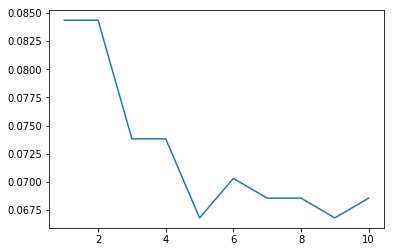

In [45]:
k = 10
errors = np.zeros(k)
for x in range(1, k + 1):
    errors[x - 1] = leave_one_out_error(values_cancer, x)
plt.plot(range(1, k + 1), errors)

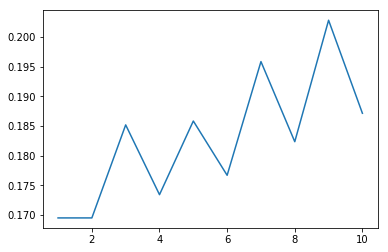

In [28]:
for x in range(1, k + 1):
        errors[x - 1] = leave_one_out_error(values_spam, x)
plt.plot(range(1, k + 1), errors)

In [46]:
from sklearn.preprocessing import MinMaxScaler
def scale_data(data_with_labels):
    labels = [r.pop(0) for r in data_with_labels]
    labels_column = [[i] for i in labels]
    scaled_data = MinMaxScaler().fit_transform(data_with_labels).tolist()
    return [i + j for i, j in zip(labels_column, scaled_data)]

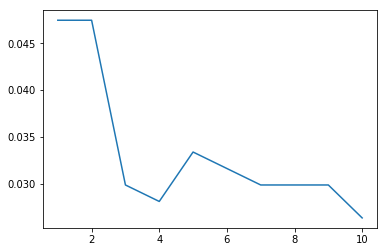

In [48]:
scaled_values_cancer = scale_data(values_cancer)
for x in range(1, k + 1):
    errors[x - 1] = leave_one_out_error(scaled_values_cancer, x)
plt.plot(range(1, k + 1), errors)        

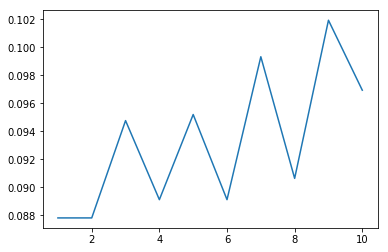

In [49]:
scaled_values_spam = scale_data(values_spam)
for x in range(1, k + 1):
    errors[x - 1] = leave_one_out_error(scaled_values_spam, x)
plt.plot(range(1, k + 1), errors)  

**Clustering**

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [52]:
dataset = pd.read_csv("blobs.csv")
values = dataset.values  

In [82]:
import math
def euclidean_distance(x, y):
    distance = 0.0
    for i in range(len(x)):
        distance += (x[i] - y[i]) * (x[i] - y[i])
    return math.sqrt(distance)

In [83]:
def k_means_cluster(values, k, epsilon=0.001, max_iterations=500, centroids={}, classes={}):
    cluster_indices = [0] * len(values)

    for i in range(k):
        centroids[i] = values[i]

    for i in range(max_iterations):
        for j in range(k):
            classes[j] = []
        for x in range(len(values)):
            value = values[x]
            distances = [euclidean_distance(value, centroids[c]) for c in centroids]
            classification = distances.index(min(distances))
            classes[classification].append(value)
            cluster_indices[x] = classification

        previous = dict(centroids)
        for classification in classes:
            centroids[classification] = np.average(classes[classification], axis=0)

        is_optimal = True
        for centroid in centroids:
            previous_centroid = previous[centroid]
            current_centroid = centroids[centroid]
            if np.sum((current_centroid - previous_centroid) / previous_centroid * 100.0) > epsilon:
                is_optimal = False

            if is_optimal:
                break

    return cluster_indices

In [84]:
def k_means_cluster_plot(values, x):
    centroids = {}
    classes = {}
    k_means_cluster(values, x, 0.001, 500, centroids, classes)

    colors = 10 * ["r", "g", "b", "k", "c"]

    for centroid in centroids:
        plt.scatter(centroids[centroid][0], centroids[centroid][1], s=111, marker="D")

    for classification in classes:
        color = colors[classification]
        for x in classes[classification]:
            plt.scatter(x[0], x[1], color=color, s=30)

    plt.show()

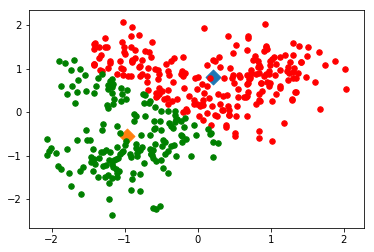

In [85]:
k_means_cluster_plot(values, 2)

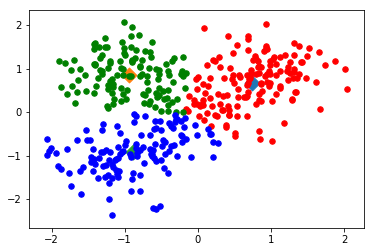

In [86]:
k_means_cluster_plot(values, 3)

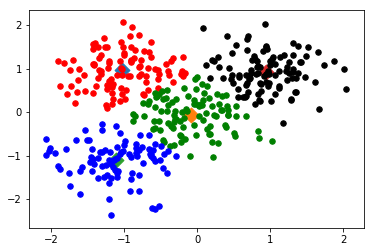

In [87]:
k_means_cluster_plot(values, 4)

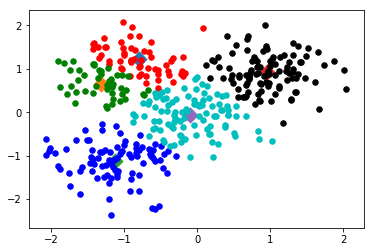

In [88]:
k_means_cluster_plot(values, 5)

In [68]:
# dbscan
def get_neighbors(values, v, eps):
    neighbors = []
    for i in range(len(values)):
        if euclidean_distance(v.tolist(), values[i].tolist()) < eps:
            neighbors.append(i)
    return neighbors


def expand_cluster(values, labels, v, neighbors, cluster_index, eps, min_points):
    labels[v] = cluster_index

    i = 0
    while i < len(neighbors):
        u = neighbors[i]
        if labels[u] == -1:
            labels[u] = cluster_index
        elif labels[u] == 0:
            labels[u] = cluster_index
            neighbors_u = get_neighbors(values, values[u], eps)
            if len(neighbors_u) >= min_points:
                neighbors = neighbors + neighbors_u
        i += 1


def dbscan_cluster(values, eps, min_points):
    labels = [0] * len(values)
    cur = 0
    for v in range(len(values)):
        if labels[v] != 0:
            continue
        neighbors = get_neighbors(values, values[v], eps)
        if len(neighbors) < min_points:
            labels[v] = -1  # noise
        else:
            cur += 1
            expand_cluster(values, labels, v, neighbors, cur, eps, min_points)

    return labels

In [69]:
def plot_dbscan(values, labels):
    clusters = len(set(labels))
    colors = ['r', 'g', 'b', 'c', 'y']
    noises = []
    points = [[] for i in range(clusters - 1)]
    for i in range(len(labels)):
        if labels[i] == -1:
            noises.append(values[i])
        else:
            points[labels[i] - 1].append(values[i])
    np_noises = np.asarray(noises)
    plt.scatter(np_noises[:, 0], np_noises[:, 1], s=10, c='k')
    for i, points in enumerate(points):
        np_points = np.asarray(points)
        plt.scatter(np_points[:, 0], np_points[:, 1], s=30, c=colors[i])
    plt.show()

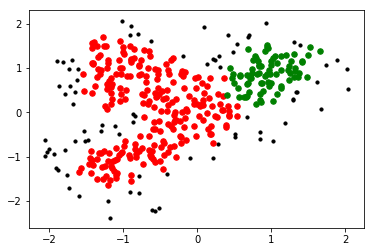

In [70]:
# 2 clusters
labels = dbscan_cluster(values, 0.21, 6)
plot_dbscan(values, labels)

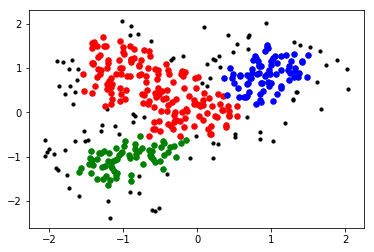

In [71]:
# 3 clusters
labels = dbscan_cluster(values, 0.21, 7)
plot_dbscan(values, labels)

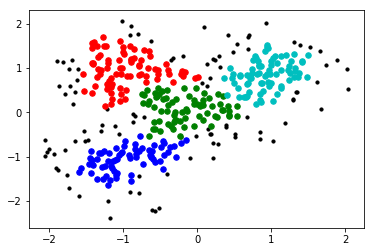

In [72]:
# 4 clusters
labels = dbscan_cluster(values, 0.209, 7)
plot_dbscan(values, labels)

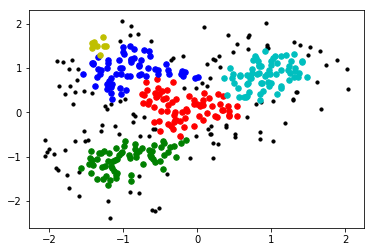

In [73]:
# 5 clusters
labels = dbscan_cluster(values, 0.209, 8)
plot_dbscan(values, labels)

In [89]:
# agglomerative clustering
from scipy.spatial import distance


def average_metric(x, y):
    z = np.concatenate([x, y])
    return np.sum(distance.pdist(z, metric='euclidean') / (len(z) * (len(z) - 1) / 2))

In [90]:
def agglomerative_clustering(values, k):
    clusters = [[x] for x in values]
    results = []

    for idx in range(len(values) - 1):
        min_value = math.inf
        x = None
        y = None
        for i in range(len(clusters)):
            for j in range(i + 1, len(clusters)):
                cur = average_metric(clusters[i], clusters[j])
                if cur < min_value:
                    min_value = cur
                    x = i
                    y = j

        clusters[x].extend(clusters[y])
        clusters.pop(y)

        # the number of clusters gradually decreases
        # so eventually we'll get to k clusters and then to 1 cluster
        if len(clusters) <= k:
            results.append([np.asarray(c) for c in clusters])
    return results

In [91]:
def plot_clusters(clusters):
    colors = 10 * ["r", "g", "b", "y", "c"]
    for i, points in enumerate(clusters):
        plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[i])
    plt.show()

In [92]:
dataset = pd.read_csv("blobs.csv")
values = dataset.values
clusters = agglomerative_clustering(values, 5)
clusters.reverse()
clusters = clusters[1:]

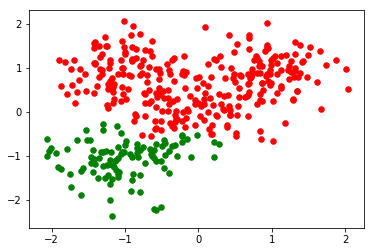

In [93]:
# 2 clusters
plot_clusters(clusters[0])

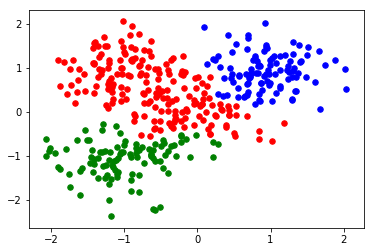

In [94]:
# 3 clusters
plot_clusters(clusters[1])

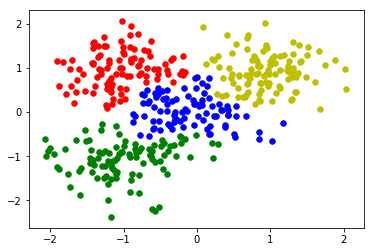

In [95]:
# 4 clusters
plot_clusters(clusters[2])

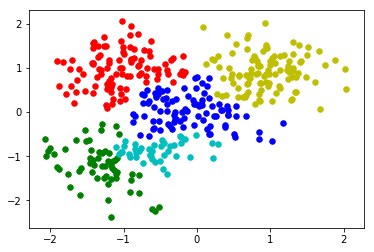

In [96]:
# 5 clusters
plot_clusters(clusters[3])

In [104]:
# purity for cancer.csv
# somehow if I don't copy the code for euclidean_distance and k_means_cluster,
# I get vastly different results, like 0.035 instead of 0.854 for 2 clusters.
# Thus the code duplication.

In [109]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import operator


def euclidean_distance(x, y):
    distance = 0.0
    for i in range(len(x)):
        distance += (x[i] - y[i]) * (x[i] - y[i])
    return math.sqrt(distance)


def k_means_cluster(values, k, epsilon=0.001, max_iterations=500, centroids={}, classes={}):
    cluster_indices = [0] * len(values)

    for i in range(k):
        centroids[i] = values[i]

    for i in range(max_iterations):
        for j in range(k):
            classes[j] = []
        for x in range(len(values)):
            value = values[x]
            distances = [euclidean_distance(value, centroids[c]) for c in centroids]
            classification = distances.index(min(distances))
            classes[classification].append(value)
            cluster_indices[x] = classification

        previous = dict(centroids)
        for classification in classes:
            centroids[classification] = np.average(classes[classification], axis=0)

        is_optimal = True
        for centroid in centroids:
            previous_centroid = previous[centroid]
            current_centroid = centroids[centroid]
            if np.sum((current_centroid - previous_centroid) / previous_centroid * 100.0) > epsilon:
                is_optimal = False

            if is_optimal:
                break

    return cluster_indices


def k_means_purity(values, k, labels):
    clusters = k_means_cluster(values, k)
    return calc_purity(values, clusters, k, labels)


def calc_purity(values, clusters, k, labels):
    result = 0

    clusters = np.asarray(clusters)
    labels = np.asarray([item for sublist in labels for item in sublist])
    for i in range(k):
        cnt = {}
        for label in labels[clusters == i]:
            cnt[label] = cnt.get(label, 0) + 1
        if len(cnt) > 0:
            result += max(cnt.items(), key=operator.itemgetter(1))[1]

    return result / len(values)

dataset = pd.read_csv("cancer.csv")
labels = dataset.iloc[:, :1].values
values = dataset.iloc[:, 1:].values
print(k_means_purity(values, 2, labels))
print(k_means_purity(values, 3, labels))
print(k_means_purity(values, 5, labels))
print(k_means_purity(values, 10, labels))

0.8541300527240774
0.8664323374340949
0.8681898066783831
0.9121265377855887


**Rules and curves**

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import MinMaxScaler


def scale_data(data_with_labels):
    labels = [r.pop(0) for r in data_with_labels]
    labels_column = [[i] for i in labels]
    scaled_data = MinMaxScaler().fit_transform(data_with_labels).tolist()
    return [i + j for i, j in zip(labels_column, scaled_data)]


def list_without_column(lst, column_index):
    return [[item for index, item in enumerate(items) if index != column_index] for items in lst]

In [111]:
def get_roc_auc_score(values, labels):
    features_number = values.shape[1]
    auc_scores = np.zeros(features_number)
    for i in range(features_number):
        feature = [row[i] for row in values]
        auc_scores[i] = roc_auc_score(labels, feature)
    return auc_scores

In [112]:
def plot_roc(tpr, fpr, title_text=""):
    plt.plot(fpr, tpr)
    plt.title(title_text)
    plt.show()


def n_best_features_roc_curve(auc_scores, values, labels, n, pos_label):
    indices = np.argsort(auc_scores)[-n:]
    best_features = values[:, indices]
    for i in range(n):
        fpr, tpr, thresholds = roc_curve(labels, best_features[:, i], pos_label)
        plot_roc(tpr, fpr, "Feature #" + str(indices[i] + 1))

[0.93751652 0.77582448 0.94689763 0.93831589 0.72204165 0.86378231
 0.93782702 0.96443766 0.69856244 0.48453438 0.86833413 0.51159426
 0.87639395 0.92641113 0.46883754 0.72728053 0.78081893 0.79179219
 0.44488928 0.62030284 0.97044289 0.78463083 0.97545056 0.9698285
 0.75405634 0.86230247 0.92136383 0.96670366 0.73693912 0.68597061]


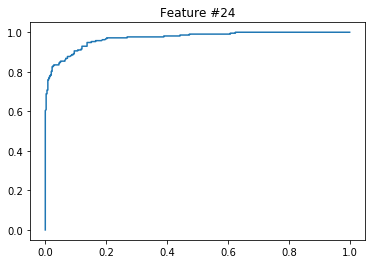

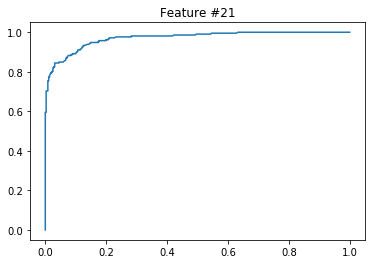

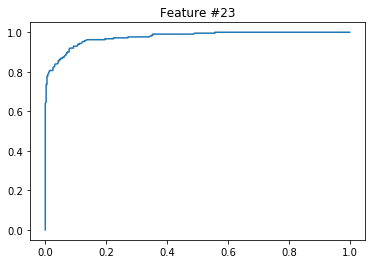

In [114]:
# cancer dataset
dataset_cancer = pd.read_csv("cancer.csv")
values_cancer = dataset_cancer.values.tolist()
scaled_values_cancer = np.asarray(list_without_column(scale_data(values_cancer), 0))
labels_cancer = dataset_cancer.iloc[:, :1]

cancer_auc_scores = get_roc_auc_score(scaled_values_cancer, labels_cancer)
print(cancer_auc_scores)
n_best_features_roc_curve(cancer_auc_scores, scaled_values_cancer, labels_cancer, 3, 'M')

[0.60463239 0.62160144 0.67531423 0.50934022 0.71093246 0.6357693
 0.70313033 0.6357601  0.61569875 0.63933385 0.63174785 0.58223467
 0.58520254 0.54104483 0.57065997 0.73272846 0.64825287 0.62931366
 0.71046814 0.59609717 0.78016592 0.52222788 0.65518966 0.67789759
 0.32393528 0.36586494 0.36333212 0.43024128 0.43836777 0.42375378
 0.4488233  0.4641313  0.45425543 0.46585882 0.43257676 0.44237843
 0.39679788 0.49965606 0.45828519 0.50859151 0.47390004 0.44748067
 0.46977938 0.46196448 0.46623096 0.43617918 0.49730456 0.4707748
 0.47793841 0.48139582 0.46360476 0.82904612 0.77213944 0.60132771
 0.78820042 0.80416257 0.76228009]


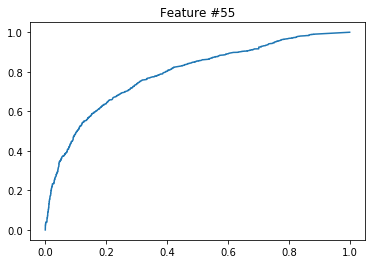

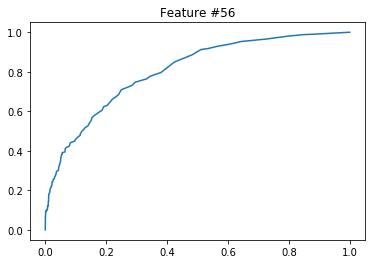

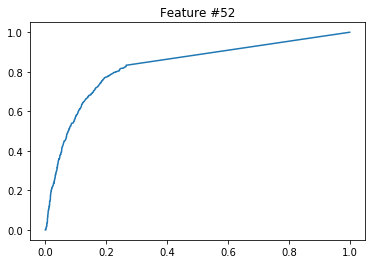

In [115]:
# spam dataset
dataset_spam = pd.read_csv("spam.csv")
initial_values_spam = dataset_spam.values
values_spam = np.c_[initial_values_spam[:, [-1]], np.delete(initial_values_spam, -1, axis=1)].tolist()
scaled_values_spam = np.asarray(list_without_column(scale_data(values_spam), 0))
labels_spam = dataset_spam.iloc[:, -1]

spam_auc_scores = get_roc_auc_score(scaled_values_spam, labels_spam)
print(spam_auc_scores)
n_best_features_roc_curve(spam_auc_scores, scaled_values_spam, labels_spam, 3, 1)

**Validation**

In [116]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter


def train_test_split(data, split, training_set, test_set):
    for x in range(len(data)):
        if random.random() < split:
            training_set.append(data[x])
        else:
            test_set.append(data[x])


def get_classes_proportions(values):
    cnt = {}
    for i in range(len(values)):
        v = values[i]
        cnt[v[0]] = cnt.get(v[0], 0) + 1
    for k in cnt:
        cnt[k] /= len(values)
    return cnt


def split_and_get_classes_proportions(values, split):
    training_set = []
    test_set = []
    train_test_split(values.tolist(), split, training_set, test_set)
    training_proportions = get_classes_proportions(training_set)
    test_proportions = get_classes_proportions(test_set)
    print("Training: " + str(training_proportions))
    print("Test: " + str(test_proportions))

In [117]:
# cancer dataset
dataset_cancer = pd.read_csv("cancer.csv")
values_cancer = dataset_cancer.values
split_and_get_classes_proportions(values_cancer, 0.8)

Training: {'M': 0.3492063492063492, 'B': 0.6507936507936508}
Test: {'M': 0.453125, 'B': 0.546875}


In [118]:
# spam dataset
dataset_spam = pd.read_csv("spam.csv")
initial_values_spam = dataset_spam.values
values_spam = np.c_[initial_values_spam[:, [-1]], np.delete(initial_values_spam, -1, axis=1)]
split_and_get_classes_proportions(values_spam, 0.8)

Training: {1.0: 0.39962172385841666, 0.0: 0.6003782761415833}
Test: {1.0: 0.3711111111111111, 0.0: 0.6288888888888889}


**Trees**